# 7. Calibration of single ended measurement with WLS and confidence intervals

A single-ended calibration is performed where the unknown parameters are estimated using fiber sections that have a reference temperature. The parameters are estimated with a weighted least squares optimization using Stokes and anti-Stokes measurements from all timesteps. Thus Stokes and anti-Stokes measurements with a large signal to noise ratio contribute more towards estimating the optimal parameter set. But an estimate of the noise variance is required.

Single-ended calibration requires a few steps. Please have a look at [1] for more information:
1. Read the raw data files loaded from your DTS machine
2. Define the reference sections: fiber sections that have a known temperature.
3. Estimate the variance of the noise in the Stokes and anti-Stokes measurements
4. Perform the parameter search and compute the temperature along the entire fiber.
5. Compute the confidence intervals for the temperature

[1]: des Tombe, B., Schilperoort, B., & Bakker, M. (2020). Estimation of Temperature and Associated Uncertainty from Fiber-Optic Raman-Spectrum Distributed Temperature Sensing. Sensors, 20(8), 2235. https://doi.org/10.3390/s20082235

In [1]:
import os
import warnings

warnings.simplefilter('ignore')  # Hide warnings to avoid clutter in the notebook


from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepath = os.path.join('..', '..', 'tests', 'data', 'single_ended')
ds = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

ds = ds.sel(x=slice(-30, 101))  # only calibrate parts of the fiber
sections = {
            'probe1Temperature':    [slice(20, 25.5)],  # warm bath
            'probe2Temperature':    [slice(5.5, 15.5)],  # cold bath
#             'referenceTemperature': [slice(-24., -4)]  # The internal coil is not so uniform
            }
ds.sections = sections

3 files were found, each representing a single timestep
4 recorded vars were found: LAF, ST, AST, TMP
Recorded at 1461 points along the cable
The measurement is single ended
Reading the data from disk


In [3]:
print(ds.calibration_single_ended.__doc__)


        Calibrate the Stokes (`ds.st`) and anti-Stokes (`ds.ast`) data to
        temperature using fiber sections with a known temperature
        (`ds.sections`) for single-ended setups. The calibrated temperature is
        stored under `ds.tmpf` and its variance under `ds.tmpf_var`.

        In single-ended setups, Stokes and anti-Stokes intensity is measured
        from a single end of the fiber. The differential attenuation is assumed
        constant along the fiber so that the integrated differential attenuation
        may be written as (Hausner et al, 2011):

        .. math::

            \int_0^x{\Delta\alpha(x')\,\mathrm{d}x'} \approx \Delta\alpha x

        The temperature can now be written from Equation 10 [1]_ as:

        .. math::

            T(x,t)  \approx \frac{\gamma}{I(x,t) + C(t) + \Delta\alpha x}

        where

        .. math::

            I(x,t) = \ln{\left(\frac{P_+(x,t)}{P_-(x,t)}\right)}


        .. math::

            C(t) = \ln{\left(\frac{\eta_-(

First calculate the variance in the measured Stokes and anti-Stokes signals, in the forward and backward direction.

The Stokes and anti-Stokes signals should follow a smooth decaying exponential. This function fits a decaying exponential to each reference section for each time step. The variance of the residuals between the measured Stokes and anti-Stokes signals and the fitted signals is used as an estimate of the variance in measured signals.

In [4]:
st_var, resid = ds.variance_stokes_constant(st_label='st')
ast_var, _ = ds.variance_stokes_constant(st_label='ast')

Similar to the ols procedure, we make a single function call to calibrate the temperature. If the method is `wls` and confidence intervals are passed to `conf_ints`, confidence intervals calculated. As weigths are correctly passed to the least squares procedure, the covariance matrix can be used. This matrix holds the covariances between all the parameters. A large parameter set is generated from this matrix, assuming the parameter space is normally distributed with their mean at the best estimate of the least squares procedure.

The large parameter set is used to calculate a large set of temperatures. By using `percentiles` or `quantile` the 95% confidence interval of the calibrated temperature between 2.5% and 97.5% are calculated.

The confidence intervals differ per time step. If you would like to calculate confidence intervals of temporal averages or of averages of fiber sections see notebook 16.

In [5]:
ds.calibration_single_ended(sections=sections,
                            st_var=st_var,
                            ast_var=ast_var,
                            method='wls')

In [6]:
ds.conf_int_single_ended(
    st_var=st_var,
    ast_var=ast_var,
    conf_ints=[2.5, 97.5],
    mc_sample_size=500)

Lets compare our calibrated values with the device calibration

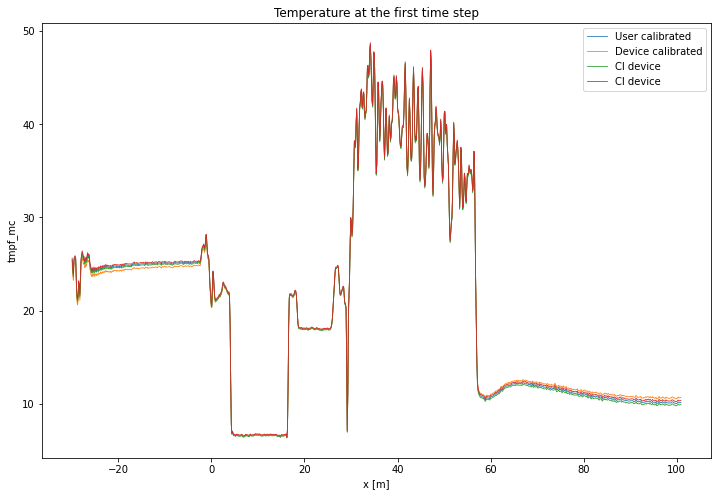

In [7]:
ds1 = ds.isel(time=0)  # take only the first timestep
ds1.tmpf.plot(linewidth=0.8, figsize=(12, 8), label='User calibrated')  # plot the temperature calibrated by us
ds1.tmp.plot(linewidth=0.8, label='Device calibrated')  # plot the temperature calibrated by the device
ds1.tmpf_mc.plot(linewidth=0.8, hue='CI', label='CI device')
plt.title('Temperature at the first time step')
plt.legend();

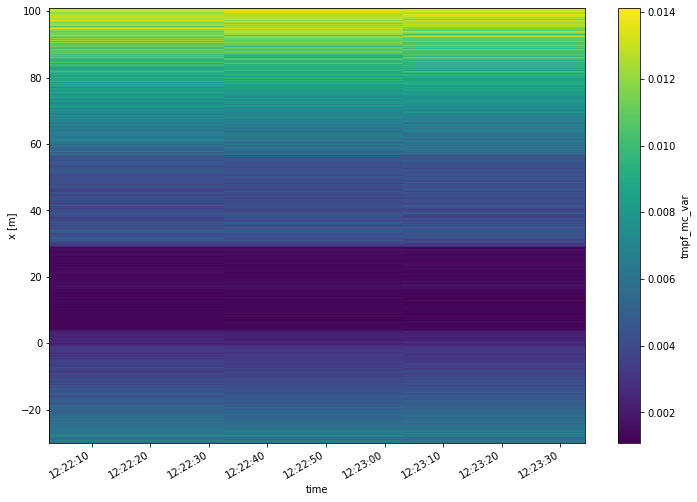

In [8]:
ds.tmpf_mc_var.plot(figsize=(12, 8));

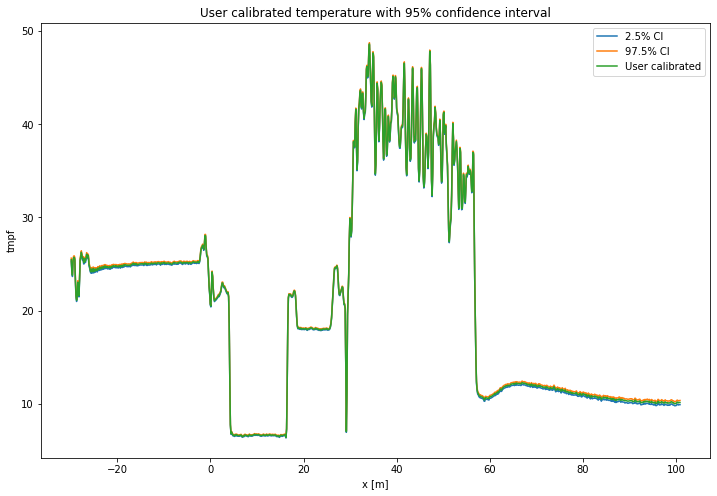

In [9]:
ds1.tmpf_mc.sel(CI=2.5).plot(label = '2.5% CI', figsize=(12, 8))
ds1.tmpf_mc.sel(CI=97.5).plot(label = '97.5% CI')
ds1.tmpf.plot(label='User calibrated')
plt.title('User calibrated temperature with 95% confidence interval')
plt.legend();

We can tell from the graph above that the 95% confidence interval widens furtherdown the cable. Lets have a look at the calculated variance along the cable for a single timestep. According to the device manufacturer this should be around 0.0059 degC.

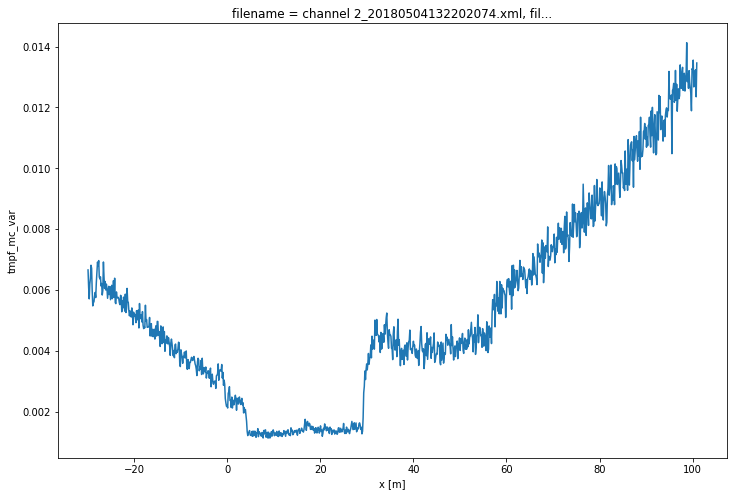

In [10]:
ds1.tmpf_mc_var.plot(figsize=(12, 8));

The variance of the temperature measurement appears to be larger than what the manufacturer reports. This is already the case for the internal cable; it is not caused by a dirty connector/bad splice on our side. Maybe the length of the calibration section was not sufficient.

At 30 m the variance sharply increases. There are several possible explanations. E.g., large temperatures or decreased signal strength.

Lets have a look at the Stokes and anti-Stokes signal.

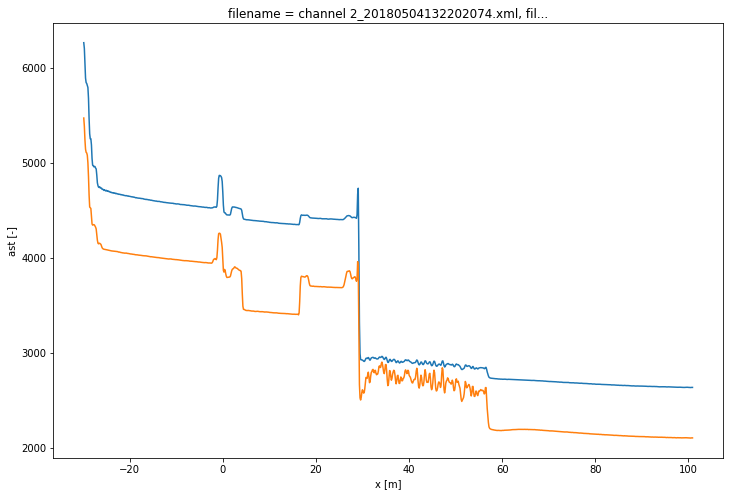

In [11]:
ds1.st.plot(figsize=(12, 8))
ds1.ast.plot();

Clearly there was a bad splice at 30 m that resulted in the sharp increase of measurement uncertainty for the cable section after the bad splice.